In [1]:
from dotenv import load_dotenv
load_dotenv()

True

# 페이지 계층구조화

In [7]:
from typing import List
from pydantic import BaseModel, Field, HttpUrl
import requests
from bs4 import BeautifulSoup
import uuid

def get_name_from_url(url: str):
    return url.split("/")[-1].split(".")[0]

class Page(BaseModel):
    id: str = Field(..., description="ID of the Page")
    link: HttpUrl = Field(description="Url link of the page")
    name: str = Field(description="Name of the page")
    parent: str = Field(default="", description="ID of the parent page")
    child: List[str] = Field(default=[], description="List of ids of the child pages")
    description: str = Field(default="", description="Description of the page")
    html_content: str = Field(default="", description="HTML code of the main content in the page")

    def __hash__(self):
        return hash((self.link, self.name))

    def __eq__(self, other):
        if not isinstance(other, Page):
            return False
        return (self.link, self.name) == (other.link, other.name)

In [73]:
import re

def clean_text(text: str) -> str:
    """
    Cleans excessive newline characters (\n) and unnecessary whitespace from the text.
    
    Args:
        text (str): Original text with excessive newlines and whitespace.
    
    Returns:
        str: Cleaned text.
    """
    text = re.sub(r'\n+', '\n', text)
    text = text.strip()
    
    return text


# 링크를 파싱하여 Page 객체 생성
def parse_links_to_pages(links: List[str]) -> List[Page]:
    pages = []
    for link in links:
        try:
            response = requests.get(link)
            soup = BeautifulSoup(response.content, "html.parser")
            
            # 메인 컨텐츠 추출 (예: <main id="main-content">)
            main_content = soup.find('main', id='main-content')
            description = main_content.text.strip() if main_content else "No main content found"
            description_clean = clean_text(description)
            # Page 객체 생성
            page = Page(
                id=str(uuid.uuid4()),
                link=link,
                name=get_name_from_url(link),
                description=description_clean,
                html_content=main_content.prettify() if main_content else "",
            )
            pages.append(page)
        except Exception as e:
            print(f"Error parsing {link}: {e}")
    
    return pages

## 퓨리오사 페이지를 최상단 페이지로 설정

In [3]:
base_url = "https://furiosa-ai.github.io/docs-dev/2024.1/en/"

root = {
    "sdk_info": Page(
        id=str(uuid.uuid4()),
        link=base_url, 
        name=get_name_from_url(base_url), 
        description="Information of RNGD SDK"
    ),
}

## 페이지 재귀탐색
- 최상단 페이지부터 시작하여 모든 서브 페이지를 가져옴
- 최대한 페이지의 본문 안에 있는 서브 페이지만 가져오도록 구현

페이지 테스트 한 번 해보기

In [4]:
import copy
from typing import Tuple
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin

url = "https://furiosa-ai.github.io/docs-dev/2024.1/en/"

# Fetch the content of the page
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")
sidebar = soup.find('div', class_='bd-sidebar-primary')
sidebar

<div class="bd-sidebar-primary bd-sidebar">
<div class="sidebar-header-items sidebar-primary__section">
</div>
<div class="sidebar-primary-items__start sidebar-primary__section">
<div class="sidebar-primary-item">
<a class="navbar-brand logo" href="#">
<img alt="FuriosaAI Developer Center 2024.1.dev0 documentation - Home" class="logo__image only-light" src="_static/furiosa-logo.webp"/>
<script>document.write(`<img src="_static/furiosa-logo.webp" class="logo__image only-dark" alt="FuriosaAI Developer Center 2024.1.dev0 documentation - Home"/>`);</script>
</a></div>
<div class="sidebar-primary-item">
<script>
 document.write(`
   <button class="btn search-button-field search-button__button" title="Search" aria-label="Search" data-bs-placement="bottom" data-bs-toggle="tooltip">
    <i class="fa-solid fa-magnifying-glass"></i>
    <span class="search-button__default-text">Search</span>
    <span class="search-button__kbd-shortcut"><kbd class="kbd-shortcut__modifier">Ctrl</kbd>+<kbd class="

In [6]:
if sidebar is None:
    print("Sidebar not found.")
else:
    # Step 2: Find all <a> tags in the sidebar
    a_tags = sidebar.find_all('a', href=True)

    # Step 3: Extract links and resolve relative URLs
    links = [urljoin(base_url, a['href']) for a in a_tags]

    # Step 4: Remove duplicates
    unique_links = list(set(links))

    # Step 5: Filter links that are under base_url
    filtered_links = [link for link in unique_links if link.startswith(base_url)]

    # Step 6: Output the filtered links
    print(f"Found {len(filtered_links)} links under {base_url}:")
    for link in filtered_links:
        print(link)

Found 21 links under https://furiosa-ai.github.io/docs-dev/2024.1/en/:
https://furiosa-ai.github.io/docs-dev/2024.1/en/furiosa_llm/furiosa-llm-serve.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/furiosa_mlperf.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/furiosa_llm/references.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/kubernetes/feature_discovery.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/software_stack.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/furiosa_llm/references/sampling_params.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/supported_models.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/furiosa_llm.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/intro.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/kubernetes/metrics_exporter.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/
https://furiosa-ai.gith

In [79]:
# 링크 리스트를 기반으로 Page 객체 생성
pages = parse_links_to_pages(filtered_links)

In [80]:
print(pages[0].description)

.rst
.pdf
OpenAI Compatible Server
 Contents 
Preparing Chat Templates
Launching the Server
Arguments for the serve command
Examples
LLaMA-3.1-70B with 4 RNGDs
LLaMA-3.1-8B with Single RNGD
Using OpenAI Client
The compatibility with OpenAI API
OpenAI Compatible Server#
The furiosa-llm package includes an OpenAI-compatible server
that can interact with OpenAI clients (and, of course, HTTP clients as well),
supporting the /v1/chat/completions and /v1/completions APIs.
In this section, we will explain how to launch the OpenAI-compatible furiosa-llm server.
Tip
You can learn more about the OpenAI API at Completions API
and Chat API.
To launch the server, you must prepare: (1) the FuriosaAI LLM Engine artifact and
(2) a chat template for the model. To download the FuriosaAI LLM Engine artifact,
follow the instructions provided through our distribution channels or contact our sales team.
To prepare the chat template, follow the instructions in the following section.
Preparing Chat Templates#

In [24]:
print(pages[0].description)

.rst
.pdf
OpenAI Compatible Server
      © Copyright 2024, FuriosaAI, Inc..


## Recursive Search: Parsing Data

In [ ]:
card_promotion_pages = parse_page(root["card_promotion"], True)


In [ ]:
# Save to file
import json

data = {
    "card_product": card_product_pages,
    "offers_and_services": offers_and_services_pages,
    "card_promotion": card_promotion_pages,
}

with open("card_page_data.json", "w") as f:
    data["card_product"] = [page.model_dump_json() for page in data["card_product"]]
    data["offers_and_services"] = [page.model_dump_json() for page in data["offers_and_services"]]
    data["card_promotion"] = [page.model_dump_json() for page in data["card_promotion"]]
    f.write(json.dumps(data))

### Parse page 

In [43]:
from bs4 import BeautifulSoup

def parse_page(
    parent_page: Page,
    links: List[str],
    recursive: bool = False,
    max_depth: int = 3,
    current_depth: int = 0,
    visited_links: set = None,  # To track visited links
) -> List[Page]:
    """
    Parses the given list of links and builds a tree of pages up to a maximum depth.
    
    Args:
        parent_page (Page): The parent page for the current parsing level.
        links (List[str]): List of URLs to parse.
        recursive (bool): Whether to recursively parse child pages.
        max_depth (int): Maximum depth for recursive parsing.
        current_depth (int): Current depth of parsing.
        visited_links (set): Set of visited links to prevent duplicates.

    Returns:
        List[Page]: List of Page objects representing the parsed tree.
    """
    # Initialize visited_links if it's None
    if visited_links is None:
        visited_links = set()

    # Stop parsing if max_depth is reached
    if current_depth >= max_depth:
        print(f"Max depth reached at {parent_page.name}")
        return []

    child_pages = []

    for link in links:
        # Skip already visited links
        if link in visited_links:
            print(f"Skipping already visited link: {link}")
            continue
        visited_links.add(link)

        # Create a new Page object for the current link
        child = Page(
            id=str(uuid.uuid4()),
            link=link,
            name=get_name_from_url(link),
            parent=parent_page.id,
        )
        parent_page.child.append(child.id)

        print(f"Parsing Page: {child.name} (Parent: {parent_page.name}) at depth {current_depth}")

        # If recursive and max_depth is not reached, parse the child page
        if recursive:
            try:
                response = requests.get(link, timeout=10)
                soup = BeautifulSoup(response.content, "html.parser")

                # Extract main content for the child
                main_content = soup.find('main', id='main-content')
                child.html_content = main_content.prettify() if main_content else ""

                # Find all valid links in the child's content
                child_links = [
                    urljoin(link, a['href'])
                    for a in soup.find_all('a', href=True)
                ]
                child_links = list(set(child_links))  # Remove duplicates
                child_links = validate_links(child_links, base_url=link)  # Validate links

                # Recursively parse child links
                child_pages.extend(
                    parse_page(child, child_links, recursive, max_depth, current_depth + 1, visited_links)
                )

            except requests.RequestException as e:
                print(f"Error fetching page {link}: {e}")

        # Add the current child to the list
        child_pages.append(child)

    return child_pages

### 초기화 및 실행

In [32]:
def validate_links(links, base_url=None):
    """
    Validates the given list of links by checking their HTTP status.
    Filters out links that are not under the given base_url.

    Args:
        links (List[str]): List of URLs to validate.
        base_url (str): Base URL to filter links. Only links starting with this URL are validated.

    Returns:
        List[str]: List of validated and accessible URLs.
    """
    valid_links = []
    for link in links:
        # If base_url is provided, filter links that do not start with base_url
        if base_url and not link.startswith(base_url):
            print(f"Skipping external link: {link}")
            continue

        try:
            # Try HEAD request first
            response = requests.head(link, timeout=5, allow_redirects=True)
            if response.status_code == 200:
                valid_links.append(link)
                continue  # Skip to the next link if HEAD is successful

            # If HEAD fails, try GET request
            print(f"HEAD request failed for {link}, trying GET...")
            response = requests.get(link, timeout=5, allow_redirects=True)
            if response.status_code == 200:
                valid_links.append(link)
            else:
                print(f"Invalid link: {link} (Status code: {response.status_code})")
        except requests.RequestException as e:
            print(f"Error validating link {link}: {e}")
    return valid_links

In [57]:
import numpy as np
np.sort(valid_links)

array(['https://furiosa-ai.github.io/docs-dev/2024.1/en/#cloud-native-toolkit',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/#customer-support',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/#device-management',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/#furiosaai-developer-center',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/#getting-started',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/#overview',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/_sources/index.rst',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/intro.html#cloudnativetoolkit',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/kubernetes.html#kubernetes',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/device_management/furiosa_smi.html#furiosasmi',
       'https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/furiosa_llm.html#gettingstartedfuriosallm',
       'https://furiosa-ai

In [48]:
# Initialize a list to store all collected links
all_links = []

# Base URL
base_url = "https://furiosa-ai.github.io/docs-dev/2024.1/en/"

# Fetch the root page
root_page = Page(
    id=str(uuid.uuid4()),
    link=base_url,
    name=get_name_from_url(base_url),
)

# Step 1: Fetch and parse the root page
response = requests.get(base_url)
soup = BeautifulSoup(response.content, "html.parser")
main_content = soup.find('main', id='main-content')

if main_content:
    # Step 2: Extract links from main content
    a_tags = main_content.find_all('a', href=True)
    links = [urljoin(base_url, a['href']) for a in a_tags]

    # Step 3: Add extracted links to all_links list
    all_links.extend(links)
    print(f"Step 2: Extracted {len(links)} links")
    print(links)

    # Step 4: Remove duplicates and validate links
    unique_links = list(set(links))
    valid_links = validate_links(unique_links, base_url=base_url)

    # Add validated links to all_links list for tracking
    all_links.extend(valid_links)
    print(f"Step 3: Validated {len(valid_links)} links")
    print(valid_links)

    # Step 5: Parse the page tree recursively
    all_pages = parse_page(root_page, valid_links, recursive=True)

    # Collect all links from parsed pages
    for page in all_pages:
        all_links.append(page.link)

    # Remove duplicates from all_links
    all_links = list(set(all_links))
    print(f"Step 5: Collected {len(all_links)} total links")
    print(all_links)
else:
    print("Main content not found in the root page.")

Step 2: Extracted 33 links
['https://furiosa-ai.github.io/docs-dev/2024.1/en/_sources/index.rst', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#overview', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#getting-started', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#cloud-native-toolkit', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#device-management', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#customer-support', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#furiosaai-developer-center', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#overview', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/rngd.html#rngd', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/software_stack.html#softwarestack', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/supported_models.html#supportedmodels', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/whatsnew/index.html#whatsnew', 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/roadmap.html#roa

In [49]:
all_pages

[Page(id='fa16277b-cafa-4a47-9b63-be79b099b409', link=HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/intro.html#cloudnativetoolkit'), name='intro', parent='fc9dc895-0860-4d14-afea-9265d73e13a9', child=[], description='', html_content='<main class="bd-main" id="main-content" role="main">\n <div class="sbt-scroll-pixel-helper">\n </div>\n <div class="bd-content">\n  <div class="bd-article-container">\n   <div class="bd-header-article d-print-none">\n    <div class="header-article-items header-article__inner">\n     <div class="header-article-items__start">\n      <div class="header-article-item">\n       <button class="sidebar-toggle primary-toggle btn btn-sm" data-bs-placement="bottom" data-bs-toggle="tooltip" title="Toggle primary sidebar">\n        <span class="fa-solid fa-bars">\n        </span>\n       </button>\n      </div>\n     </div>\n     <div class="header-article-items__end">\n      <div class="header-article-item">\n       <div class="article-

In [52]:
from urllib.parse import urlsplit, urlunsplit

def clean_and_deduplicate_links(links):
    """
    Cleans and deduplicates a list of links.

    Args:
        links (List[str]): List of links to clean.

    Returns:
        List[str]: Deduplicated and cleaned links.
    """
    cleaned_links = []
    for link in links:
        # Convert HttpUrl to string if necessary
        if isinstance(link, HttpUrl):
            link = str(link)

        # Remove anchors (#...)
        link = urlsplit(link)
        link = urlunsplit((link.scheme, link.netloc, link.path, "", ""))

        # Add to cleaned list if not already present
        if link not in cleaned_links:
            cleaned_links.append(link)

    return cleaned_links


# Clean and deduplicate links
cleaned_links = clean_and_deduplicate_links(all_links)
print(f"Cleaned Links ({len(cleaned_links)}):")
for link in cleaned_links:
    print(link)

# Parse pages using cleaned links
all_pages = []
for link in cleaned_links:
    page = Page(
        id=str(uuid.uuid4()),
        link=link,
        name=get_name_from_url(link),
    )
    all_pages.append(page)

print(f"Parsed Pages ({len(all_pages)}):")
for page in all_pages:
    print(page)

Cleaned Links (17):
https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/intro.html
https://furiosa-ai.github.io/docs/latest/en/
https://furiosa-ai.github.io/docs-dev/2024.1/en/
https://furiosa-ai.github.io/docs-dev/2024.1/en/_sources/index.rst
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/supported_models.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/furiosa_mlperf.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/device_management/furiosa_smi.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/rngd.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/software_stack.html
https://furiosa-ai.atlassian.net/servicedesk/customer/portals/
https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/kubernetes.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/prerequisites.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/roadmap.html
https://furiosa-ai.github.io/docs-dev/2024.1/en/

In [51]:
all_links

['https://furiosa-ai.github.io/docs-dev/2024.1/en/cloud_native_toolkit/intro.html#cloudnativetoolkit',
 'https://furiosa-ai.github.io/docs/latest/en/',
 HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/#customer-support'),
 'https://furiosa-ai.github.io/docs-dev/2024.1/en/#furiosaai-developer-center',
 'https://furiosa-ai.github.io/docs-dev/2024.1/en/_sources/index.rst',
 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/supported_models.html#supportedmodels',
 HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/getting_started/furiosa_mlperf.html#gettingstartedfuriosamlperf'),
 HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/device_management/furiosa_smi.html#furiosasmi'),
 HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/rngd.html#id1'),
 HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/#getting-started'),
 'https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/software_stack.html#softwarestack',
 HttpUrl('https://furiosa-ai.g

In [31]:
# Step 2: Extract links from main content
a_tags = main_content.find_all('a', href=True)
links = [urljoin(base_url, a['href']) for a in a_tags]


TypeError: validate_links() got an unexpected keyword argument 'base_url'

In [30]:
len(validated_links)

19

In [ ]:


# Step 4: Parse the page tree recursively
all_pages = parse_page(root_page, valid_links, recursive=True)

### 홈페이지 구조별 표시

In [19]:
def print_recursively(root_page: Page, pages: List[Page]):
    sub_pages = [p for p in pages for cid in root_page.child if p.id == cid]
    print(f"{root_page.name} -> {[p.name for p in sub_pages]}")
    for p in sub_pages:
        print_recursively(p, pages)

In [21]:
root["sdk_info"]

Page(id='546572f9-3ca2-48c8-8b4d-e54c002b7737', link=HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/'), name='', parent='', child=[], description='Information of RNGD SDK', html_content='')

In [20]:
print_recursively(root["sdk_info"], unique_links)

 -> []


In [7]:

# Step 3: Find all div tags under "main-content" whose class starts with "thumb"
thumb_divs = main_content.find_all('div', class_=lambda x: x and x.startswith('thumb'))

# Step 4: Exclude thumb divs that have a child div with class "quick-access-thumb"
filtered_thumb_divs = [
    div for div in thumb_divs 
    if not div.find('div', class_='quick-access-thumb') 
    and 'visibility: hidden' not in div.get('style', '')
]

Extracted Main Content:
<main class="bd-main" id="main-content" role="main">
 <div class="sbt-scroll-pixel-helper">
 </div>
 <div class="bd-content">
  <div class="bd-article-container">
   <div class="bd-header-article d-print-none">
    <div class="header-article-items header-article__inner">
     <div class="header-article-items__start">
      <div class="header-article-item">
       <button class="sidebar-toggle primary-toggle btn btn-sm" data-bs-placement="bottom" data-bs-toggle="tooltip" title="Toggle primary sid


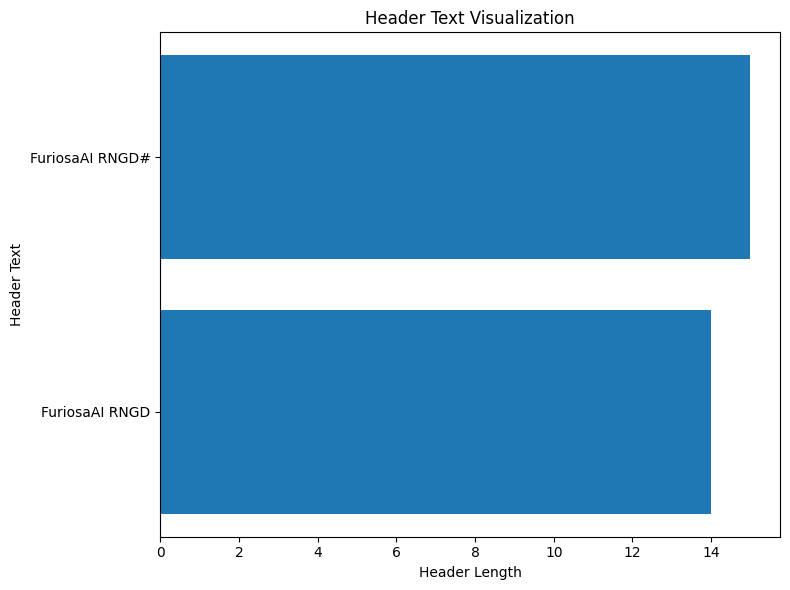

Extracted Links from Main Content:
../_sources/overview/rngd.rst
#furiosaai-rngd
../_images/rngd_card.webp
../_images/rngd_card.webp
https://ieeexplore.ieee.org/document/10609575
https://furiosa.ai/download/FuriosaAI-tensor-contraction-processor-isca24
https://hc2024.hotchips.org/#clip=8jnhm5vdlsow
https://furiosa.ai/blog/tensor-contraction-processor-ai-chip-architecture
#id1
../index.html
software_stack.html


In [48]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

# URL to fetch
url = "https://furiosa-ai.github.io/docs-dev/2024.1/en/overview/rngd.html"

# Fetch the page content
response = requests.get(url)
response.raise_for_status()
html_content = response.content

# Parse the HTML with BeautifulSoup
soup = BeautifulSoup(html_content, "html.parser")

# Extract and visualize the structure of the main content
main_content = soup.find('main', id='main-content')  # Using <main> with id='main-content'
if main_content:
    # Print a summary of the main content
    print("Extracted Main Content:")
    print(main_content.prettify()[:500])  # Preview the first 500 characters
else:
    print("Main content not found. Trying an alternative approach.")

    # If 'main-content' doesn't exist, print the full structure
    print("HTML Structure Overview:")
    print(soup.prettify()[:500])  # Show only the first 500 characters

# Visualizing HTML structure using an example
# Extract <h1> and <h2> tags from the page for a simple visualization
headers = soup.find_all(['h1', 'h2'])
header_texts = [header.get_text() for header in headers]

# Visualize extracted headers
plt.figure(figsize=(8, 6))
plt.barh(range(len(header_texts)), [len(text) for text in header_texts], tick_label=header_texts)
plt.xlabel("Header Length")
plt.ylabel("Header Text")
plt.title("Header Text Visualization")
plt.tight_layout()
plt.show()

# Parsing example: Extract all links within the main content
if main_content:
    links = main_content.find_all('a', href=True)
    extracted_links = [link['href'] for link in links]
    print("Extracted Links from Main Content:")
    for link in extracted_links:
        print(link)

In [44]:
print(main_content)

None


In [35]:
print(main_content)

None


In [38]:
import copy
from typing import Tuple
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, urljoin

def is_avaliable(url: str) -> bool:
    res = requests.get(url)
    return res.status_code == 200

def parse_page(parent_page: Page, recursive: bool = False) -> List[Page]:

    # Fetch the content of the page
    response = requests.get(parent_page.link)
    soup = BeautifulSoup(response.content, "html.parser")

    # Step 2: Find the div with class "main-content"
    main_content = soup.find('div', id='main-content')
    if not main_content:
        print("Main content not found")
        return []

    if main_content is None:
        return []

    # Step 3: Find all div tags under "main-content" whose class starts with "thumb"
    thumb_divs = main_content.find_all('div', class_=lambda x: x and x.startswith('thumb'))

    # Step 4: Exclude thumb divs that have a child div with class "quick-access-thumb"
    filtered_thumb_divs = [
        div for div in thumb_divs 
        if not div.find('div', class_='quick-access-thumb') 
        and 'visibility: hidden' not in div.get('style', '')
    ]

    # Step 5: Extract href from a tags within the filtered_thumb_divs
    hrefs = []
    for div in filtered_thumb_divs:
        a_tag = div.find('a')  # Find the first <a> tag within each filtered div
        if a_tag and a_tag.get('href'):
            hrefs.append(a_tag['href'])

    child_pages: List[Page] = []
    # Output the extracted hrefs
    for href in hrefs:
        if href.startswith("#") or href.startswith("tel"):
            print(href, "skipped")
            continue
        parsed_url = urlparse(href)
        if not (parsed_url.scheme in ["http", "https"] and parsed_url.netloc):
            href = str(urljoin(base=base_url, url=href))
        print(href)
        child = Page(id=str(uuid.uuid4()), link=href, name=get_name_from_url(href), parent=parent_page.id)
        if recursive and is_avaliable(child.link):
            child_pages.extend(parse_page(child, recursive))
        child_pages.append(child)
        parent_page.child.append(child.id)
    child_pages = list(set(child_pages))

    return child_pages

In [12]:
def print_recursively(root_page: Page, pages: List[Page]):
    sub_pages = [p for p in pages for cid in root_page.child if p.id == cid]
    print(f"{root_page.name} -> {[p.name for p in sub_pages]}")
    for p in sub_pages:
        print_recursively(p, pages)

## Recursive Search: Overview

In [21]:
root["sdk_info"]

Page(id='9c00dccd-8c7d-4cdc-970f-7b2deebe9fab', link=HttpUrl('https://furiosa-ai.github.io/docs-dev/2024.1/en/'), name='', parent='', child=[], description='Information of RNGD SDK', html_content='')

In [39]:
all_pages = parse_page(root["sdk_info"], True)
print(all_pages)

Main content not found
[]


In [12]:
card_product_pages = parse_page(root["card_product"], True)
card_product_pages.append(root["card_product"])

https://shinhan.com.vn/en/shinhan_card_category/consumer-credit-card.html
https://shinhan.com.vn/en/card/365-cashback-platinum-credit-card.html
https://shinhan.com.vn/en/card/tiki-shinhan-platinum-credit-card.html
https://shinhan.com.vn/en/card/tiki-shinhan-classic-credit-card.html
https://shinhan.com.vn/en/card/baemin-shinhan-credit-card.html
https://shinhan.com.vn/en/card/shinhan-visa-signature-credit-card.html
https://shinhan.com.vn/en/card/visa-platinum-pwm-credit-card.html
https://shinhan.com.vn/en/card/visa-travel-platinum-credit-card.html
https://shinhan.com.vn/en/card/korean-air-shinhan-consumer-credit-card.html
https://shinhan.com.vn/en/card/visa-international-shinhan-lotte-mart-credit-card.html
https://shinhan.com.vn/en/card/visa-platinum-hi-point-credit-card.html
https://shinhan.com.vn/en/card/visa-gold-hi-point-credit-card.html
https://shinhan.com.vn/en/card/visa-classic-hi-point-credit-card.html
https://shinhan.com.vn/en/card/visa-platinum-cash-back-credit-card.html
https:

In [13]:
len(card_product_pages)
print_recursively(root["card_product"], card_product_pages)

card-product -> ['consumer-debit-card', 'corporate-debit-card', 'corporate-credit-card', 'card-comparison', 'consumer-credit-card']
consumer-debit-card -> ['shinhan-pwm-debit-mastercard', 'hutech-shinhan-debit-card', 'visa-international-shinhan-my-sol-debit-card', 'domestic-atm-card', 'shinhan-be-safe-debit-card', 'visa-international-classic-debit-card', 'visa-international-shinhan-lotte-mart-debit-card', 'visa-pwm-international-classic-debit-card']
shinhan-pwm-debit-mastercard -> []
hutech-shinhan-debit-card -> []
visa-international-shinhan-my-sol-debit-card -> []
domestic-atm-card -> []
shinhan-be-safe-debit-card -> []
visa-international-classic-debit-card -> []
visa-international-shinhan-lotte-mart-debit-card -> []
visa-pwm-international-classic-debit-card -> []
corporate-debit-card -> ['korcham-shinhan-corporate-debit-card', 'kocham-shinhan-corporate-debit-card', 'shinhan-visa-corporate-debit-card']
korcham-shinhan-corporate-debit-card -> []
kocham-shinhan-corporate-debit-card -> [

## Recursive Search: Card Offers and Services Page

In [14]:
offers_and_services_pages = parse_page(root["card_offers_and_services"], True)
offers_and_services_pages.append(root["card_offers_and_services"])

https://shinhan.com.vn/en/shinhan_card_category_service/installment-plan.html
https://shinhan.com.vn/en/shinhan-installment-plan
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
https://shinhan.com.vn/en/page/flexible-installment-plan-with-preferential-interest-2.html
https://shinhan.com.vn/en/card/shinhan-flexi-cash-with-shinhan-credit-card.html
https://shinhan.com.vn/en/shinhan-zone
https://shinhan.com.vn/en/shinhan_zone_category/food-beverage-2.html
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
https://shinhan.com.vn/en/shinhan_zone_category/health-care-beauty-2.html
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skipped
#popup-card skippe

In [15]:
print(len(offers_and_services_pages))
print_recursively(root["card_offers_and_services"], offers_and_services_pages)

18
card-offers-and-services -> ['installment-plan', 'shinhan-garmin-pay-2', 'shinhan-samsung-pay-2', 'shinhan-zone', 'shinhan-google-pay', 'shinhan-point-2', 'bill-payment-service-via-shinhan-credit-card', 'shinhan-flexi-cash-with-shinhan-credit-card']
installment-plan -> ['flexible-installment-plan-with-preferential-interest-2', 'shinhan-installment-plan']
flexible-installment-plan-with-preferential-interest-2 -> []
shinhan-installment-plan -> []
shinhan-garmin-pay-2 -> []
shinhan-samsung-pay-2 -> ['pre-order-samsung-galaxy-s9-s9-with-shinhan-credit-card-2']
pre-order-samsung-galaxy-s9-s9-with-shinhan-credit-card-2 -> []
shinhan-zone -> ['travel-accommodation-2', 'health-care-beauty-2', 'shinhan-premier-privileges', 'others-2', 'shopping-2', 'food-beverage-2']
travel-accommodation-2 -> []
health-care-beauty-2 -> []
shinhan-premier-privileges -> []
others-2 -> []
shopping-2 -> []
food-beverage-2 -> []
shinhan-google-pay -> []
shinhan-point-2 -> []
bill-payment-service-via-shinhan-credi

## Recursive Search: Card Promotion Page

In [16]:
card_promotion_pages = parse_page(root["card_promotion"], True)
card_promotion_pages.append(root["card_promotion"])

https://shinhan.com.vn/en/promotion/cashback-for-first-spending-transaction.html
https://shinhan.com.vn/en/promotion/convergence-offer-enjoy-delicious-cuisine-and-healthy-living-with-shinhan-be-safe-debit-card.html
https://shinhan.com.vn/en/promotion/refer-card-to-your-besties.html
https://shinhan.com.vn/en/promotion/back-to-school-with-sweet-offer.html
https://shinhan.com.vn/en/promotion/explore-new-benefit-and-receive-sweet-gifts.html
https://shinhan.com.vn/en/promotion/e-voucher-golf-when-opening-shinhan-corporate-credit-card.html


In [17]:
print(len(card_promotion_pages))
print_recursively(root["card_promotion"], card_promotion_pages)

7
card -> ['cashback-for-first-spending-transaction', 'convergence-offer-enjoy-delicious-cuisine-and-healthy-living-with-shinhan-be-safe-debit-card', 'refer-card-to-your-besties', 'back-to-school-with-sweet-offer', 'explore-new-benefit-and-receive-sweet-gifts', 'e-voucher-golf-when-opening-shinhan-corporate-credit-card']
cashback-for-first-spending-transaction -> []
convergence-offer-enjoy-delicious-cuisine-and-healthy-living-with-shinhan-be-safe-debit-card -> []
refer-card-to-your-besties -> []
back-to-school-with-sweet-offer -> []
explore-new-benefit-and-receive-sweet-gifts -> []
e-voucher-golf-when-opening-shinhan-corporate-credit-card -> []


## Fill Page's data
- 각 페이지의 본문 html 컨텐츠와 요약 생성

In [18]:
import copy
import json
import requests
from bs4 import BeautifulSoup
from langchain_core.prompts import PromptTemplate
from langchain_ollama.llms import OllamaLLM
from langchain_core.output_parsers.string import StrOutputParser
from langchain_core.documents import Document as LangchainDocument
from llama_index.core import Document as LlamaIndexDocument


prompt = PromptTemplate.from_template("""As an expert in web content summarization, generate a clear and concise overview of the provided web page. 
Your summary should be limited to three sentences, effectively capturing the main theme and purpose of the page without going into detailed specifics. 
Focus on delivering a high-level understanding that conveys the core message and intent of the content.
Do not start with opening sentence like "Here is...", just only answer.

{web_page}

SUMMARY OVERVIEW:
""")

# model = "llama3.1"
# model = "llama3.1-70B-IQ2-XS"
# model = "phi3:medium"
model = "llama3.1:70b"
llm = OllamaLLM(model=model, base_url="https://ollama.dudaji.com", temperature=0)

chain = prompt | llm | StrOutputParser()

def map_page_content(page: Page) -> Page:
    modified_page = copy.deepcopy(page)
    response = requests.get(modified_page.link)
    soup = BeautifulSoup(response.content, "html.parser")
    content = soup.find("div", id="page-wrapper")
    if content is not None:
        filter_tag = content.find_all(['footer', 'script'])
        if not filter_tag:
            for tag in filter_tag:
                tag.decompose()
    modified_page.html_content = str(content)
    return modified_page


def map_page_description(page: Page) -> Page:
    modified_page = copy.deepcopy(page)
    modified_page.description = chain.invoke({"web_page": modified_page.html_content})
    return modified_page

def convert_page_to_langchain_document(page: Page) -> LangchainDocument:
    return LangchainDocument(
        metadata={
            "id": page.id,
            "source": str(page.link),
            "title": page.name,
            "parent_doc_id": page.parent,
            "child_doc_ids": json.dumps(page.child),
            "description": page.description,
        },
        page_content=page.html_content,
    )

def convert_page_to_llama_index_document(page: Page) -> LlamaIndexDocument:
    return LlamaIndexDocument(
        doc_id=page.id,
        metadata={
            "source": str(page.link),
            "title": page.name,
            "parent_doc_id": page.parent,
            "child_doc_ids": json.dumps(page.child),
            "description": page.description,
        },
        text=page.html_content,
    )    


## Save recursive page data
- 위에서 재귀 탐색으로 얻은 페이지들을 json 파일로 저장

In [19]:
# Save to file
import json

data = {
    "card_product": card_product_pages,
    "offers_and_services": offers_and_services_pages,
    "card_promotion": card_promotion_pages,
}

with open("card_page_data.json", "w") as f:
    data["card_product"] = [page.model_dump_json() for page in data["card_product"]]
    data["offers_and_services"] = [page.model_dump_json() for page in data["offers_and_services"]]
    data["card_promotion"] = [page.model_dump_json() for page in data["card_promotion"]]
    f.write(json.dumps(data))


In [20]:
# Load from file
data = {}
with open("card_page_data.json", "r") as f:
    data = json.load(f)
    data["card_product"] = [Page.model_validate_json(page) for page in data["card_product"]]
    data["offers_and_services"] = [Page.model_validate_json(page) for page in data["offers_and_services"]]
    data["card_promotion"] = [Page.model_validate_json(page) for page in data["card_promotion"]]

In [22]:
print(len(data["card_product"]))
print(len(data["offers_and_services"]))
print(len(data["card_promotion"]))

42
18
7


## Fill html
- 각 페이지의 본문 html 컨텐츠 가져옴

In [23]:
card_product_pages_with_content = [map_page_content(page) for page in data["card_product"]]
offers_and_services_pages_with_content = [map_page_content(page) for page in data["offers_and_services"]]
card_promotion_pages_with_content= [map_page_content(page) for page in data["card_promotion"]]

In [31]:
print(card_product_pages_with_content[0])
print(offers_and_services_pages_with_content[0])
print(card_promotion_pages_with_content[0])

id='4ef28884-7f40-47ff-981b-89eed53dea67' link=Url('https://shinhan.com.vn/en/card/baemin-shinhan-credit-card.html') name='baemin-shinhan-credit-card' parent='a4249367-aed1-4776-811f-9670c8c820cb' child=[] description='' html_content='<div id="page-wrapper"><div class="banner-top banner-card-productgroup"><img alt="" src="https://shinhan.com.vn/public/uploads/card/2022/Products/Card%20product/Baemin%20banner.jpg"/><div class="container"><div class="text-w"><div class="bread"><a href="https://shinhan.com.vn/en">Home</a><span>&gt;</span><a href="/en/page/card-product.html">Card</a><span>&gt;</span><a href="#">BAEMIN – Shinhan Credit Card</a></div><h2 class="title">BAEMIN – Shinhan Credit Card</h2></div></div></div><div class="tab-w" id="tabNav"><div class="container"><div class="selected"><span></span></div><div class="list-tab" id="slide-tab"><div class="tab"><a class="active" href="#introduction"><span>Introduction</span></a></div><div class="tab"><a href="#top-reasons"><span>Top Reaso

## Fill description
- 각 페이지를 설명하는 요약을 LLM으로 생성하여 추가

In [24]:
card_product_final_pages = [map_page_description(page) for page in card_product_pages_with_content]
offers_and_services_final_pages = [map_page_description(page) for page in offers_and_services_pages_with_content]
card_promotion_final_pages = [map_page_description(page) for page in card_promotion_pages_with_content]

In [26]:
# Save to file

data = {}
with open("card_page_with_description.json", "w") as f:
    data["card_product"] = [page.model_dump_json() for page in card_product_final_pages]
    data["offers_and_services"] = [page.model_dump_json() for page in offers_and_services_final_pages]
    data["card_promotion"] = [page.model_dump_json() for page in card_promotion_final_pages]
    f.write(json.dumps(data))

In [27]:
data["card_product"]

['{"id":"beebee06-ad16-40e3-b3a0-59fba08fe81e","link":"https://shinhan.com.vn/en/card/kocham-shinhan-corporate-credit-card.html","name":"kocham-shinhan-corporate-credit-card","parent":"be56b4cc-b45e-4b8b-9e2a-f0b3d84ce949","child":[],"description":"The Shinhan Visa Corporate Credit Card is a credit card service offered by Shinhan Bank Vietnam, designed for corporations, organizations, and institutions. The card provides various benefits, including exclusive privileges, special offers, and a convenient bill payment service.\\n\\nTo be eligible for the card, the applicant must meet certain criteria, such as having a corporate bank account at Shinhan Bank Vietnam and being a member of the Korean Chamber of Commerce in Vietnam (KOCHAM).\\n\\nThe required documents for application include:\\n\\n* Card Application\\n* Business License/Investment License\\n* Tax Code Certificate\\n* Seal & Registered Stamp certificate\\n* The Company\'s Charter\\n* CEO\'s ID card or passport\\n* Delegator\'s 

In [28]:
# Load from file
import json
with open("card_page_with_description.json", "r") as f:
    data = json.load(f)
    card_product_fial_pages = [Page.model_validate_json(page) for page in data["card_product"]]
    offers_and_services_final_pages = [Page.model_validate_json(page) for page in data["offers_and_services"]]
    card_promotion_final_pages = [Page.model_validate_json(page) for page in data["card_promotion"]]

### Llama Index
- vectordb와 bm25에 저장하여 retriever 성능 테스트
- Langchain bm25는 persistence를 지원하지 않음

In [28]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# model_kwargs = {"tokenizer_kwargs": {"device_map": "auto"}}
embedding = HuggingFaceEmbedding(model_name="dunzhang/stella_en_1.5B_v5")

/home/dudaji/anaconda3/envs/shinhan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
from llama_index.core import Document as LlamaIndexDocument
card_product_nodes = [convert_page_to_llama_index_document(page) for page in card_product_final_pages]
card_product_description_nodes = [LlamaIndexDocument(id_=node.id_, metadata=node.metadata, text=node.metadata["description"]) for node in card_product_nodes]

offers_and_services_nodes = [convert_page_to_llama_index_document(page) for page in offers_and_services_final_pages]
offers_and_services_description_nodes = [LlamaIndexDocument(id_=node.id_, metadata=node.metadata, text=node.metadata["description"]) for node in offers_and_services_nodes]

card_promotion_nodes = [convert_page_to_llama_index_document(page) for page in card_promotion_final_pages]
card_promotion_description_nodes = [LlamaIndexDocument(id_=node.id_, metadata=node.metadata, text=node.metadata["description"]) for node in card_promotion_nodes]

In [40]:
from typing import List
import chromadb
from llama_index.core import VectorStoreIndex
from llama_index.core import StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore
from llama_index.core.retrievers import VectorIndexRetriever
import Stemmer
from llama_index.retrievers.bm25 import BM25Retriever


persist_dir = "./shinhan_chroma"
def get_and_store_chroma_retriever(collection_name: str, nodes: List[LlamaIndexDocument], *, k: int = 2, load: bool = False) -> VectorIndexRetriever:
    chroma_client = chromadb.PersistentClient(path=persist_dir)
    chroma_collection = chroma_client.get_or_create_collection(collection_name)
    vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    if load:
        index = VectorStoreIndex.from_vector_store(vector_store, storage_context=storage_context, embed_model=embedding)
    else:
        index = VectorStoreIndex.from_documents(nodes, storage_context=storage_context, embed_model=embedding)
    return VectorIndexRetriever(index=index, similarity_top_k=k)

def get_and_store_bm25_retriever(bm25_persist_dir: str, nodes: List[LlamaIndexDocument], k: int = 2) -> BM25Retriever:
    bm25_retriever = BM25Retriever.from_defaults(
        nodes=nodes,
        similarity_top_k=k,
        stemmer=Stemmer.Stemmer("english"),
        language="en",
    )
    bm25_retriever.persist(bm25_persist_dir)
    return bm25_retriever


In [33]:
card_product_retriever = get_and_store_chroma_retriever("card_product_page", card_product_nodes)
offers_and_services_retriever = get_and_store_chroma_retriever("offers_and_services", offers_and_services_nodes)
card_promotion_retriever = get_and_store_chroma_retriever("card_promotion", card_promotion_nodes)

In [35]:
card_product_description_retriever = get_and_store_chroma_retriever("card_product_description", card_product_description_nodes)
offers_and_servicesdescription_retriever = get_and_store_chroma_retriever("offers_and_services_description", offers_and_services_description_nodes)
card_promotion_description_retriever = get_and_store_chroma_retriever("card_promotion_description", card_promotion_description_nodes)

In [36]:
retrieved_nodes = card_product_retriever.retrieve("Provide a list of consumer credit card products")
[node.metadata["source"] for node in retrieved_nodes]

['https://shinhan.com.vn/en/shinhan_card_category/consumer-credit-card.html',
 'https://shinhan.com.vn/en/shinhan_card_category/consumer-credit-card.html']

In [39]:
retrieved_nodes = card_product_description_retriever.retrieve("Provide a list of consumer credit card products")
[node.metadata["source"] for node in retrieved_nodes]

['https://shinhan.com.vn/en/shinhan_card_category/consumer-credit-card.html']

In [41]:
retrieved_nodes = offers_and_services_retriever.retrieve("Tell me about Installment plan")
[node.metadata["source"] for node in retrieved_nodes]

['https://shinhan.com.vn/en/page/flexible-installment-plan-with-preferential-interest-2.html',
 'https://shinhan.com.vn/en/page/flexible-installment-plan-with-preferential-interest-2.html']

In [38]:
page_bm25_retriever = get_and_store_bm25_retriever("shinhan_card_product_bm25", card_product_nodes)

Finding newlines for mmindex: 100%|██████████| 624k/624k [00:00<00:00, 656MB/s]


In [50]:
nodes = page_bm25_retriever.retrieve("Provide a list of consumer credit card products")
[node.metadata["source"] for node in nodes]

['https://shinhan.com.vn/en/card/shinhan-pwm-debit-mastercard.html',
 'https://shinhan.com.vn/en/card/hutech-shinhan-debit-card.html']

In [42]:
description_bm25_retriever = get_and_store_bm25_retriever("shinhan_card_product_bm25_description", card_product_description_nodes)

Finding newlines for mmindex: 100%|██████████| 152k/152k [00:00<00:00, 155MB/s]


In [51]:
description_bm25_retriever.retrieve("Provide a list of consumer credit card products")
[node.metadata["source"] for node in nodes]

['https://shinhan.com.vn/en/card/shinhan-pwm-debit-mastercard.html',
 'https://shinhan.com.vn/en/card/hutech-shinhan-debit-card.html']

In [55]:
[node.metadata["source"] for node in card_product_description_nodes]

['https://shinhan.com.vn/en/card/shinhan-visa-corporate-debit-card.html',
 'https://shinhan.com.vn/en/card/tiki-shinhan-platinum-credit-card.html',
 'https://shinhan.com.vn/en/card/kocham-shinhan-corporate-debit-card.html',
 'https://shinhan.com.vn/en/shinhan_card_category/corporate-credit-card.html',
 'https://shinhan.com.vn/en/card/korcham-shinhan-corporate-debit-card.html',
 'https://shinhan.com.vn/en/card/365-cashback-platinum-credit-card.html',
 'https://shinhan.com.vn/en/card/visa-gold-hi-point-credit-card.html',
 'https://shinhan.com.vn/en/card/shinhan-corporate-world-credit-card.html',
 'https://shinhan.com.vn/en/card/kocham-shinhan-corporate-credit-card.html',
 'https://shinhan.com.vn/en/card/korean-air-shinhan-consumer-credit-card.html',
 'https://shinhan.com.vn/en/card/visa-international-classic-debit-card.html',
 'https://shinhan.com.vn/en/card/visa-travel-platinum-credit-card.html',
 'https://shinhan.com.vn/en/card/visa-credit-e-card.html',
 'https://shinhan.com.vn/en/shin